In [191]:
import nltk
import pandas as pd
import numpy as np
import matplotlib

In [192]:
inputFile="../data/labeled/labeled_data.csv"
df = pd.read_csv(inputFile)
#df=df[1:500000]

# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
 



labeled_data=df[df['class']!= '-1'].copy()

#encode the classes to their index 
labeled_data['labels']=labeled_data['class'].apply( classes.index)
print(classes)


['unisex', 'men', 'women', 'kid', 'baby']


In [193]:
# Helper Functions

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()


# Bag of Words Counts 

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,2))
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


list_corpus = labeled_data["all_text"].tolist()
list_labels = labeled_data["labels"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, 
                                                    list_labels, test_size=0.2,
                                                     random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)



In [195]:
X_train_counts.shape

(87960, 276262)

## Visualizing the embeddings
Since visualizing data in large dimensions is hard, let's project it down to 2.

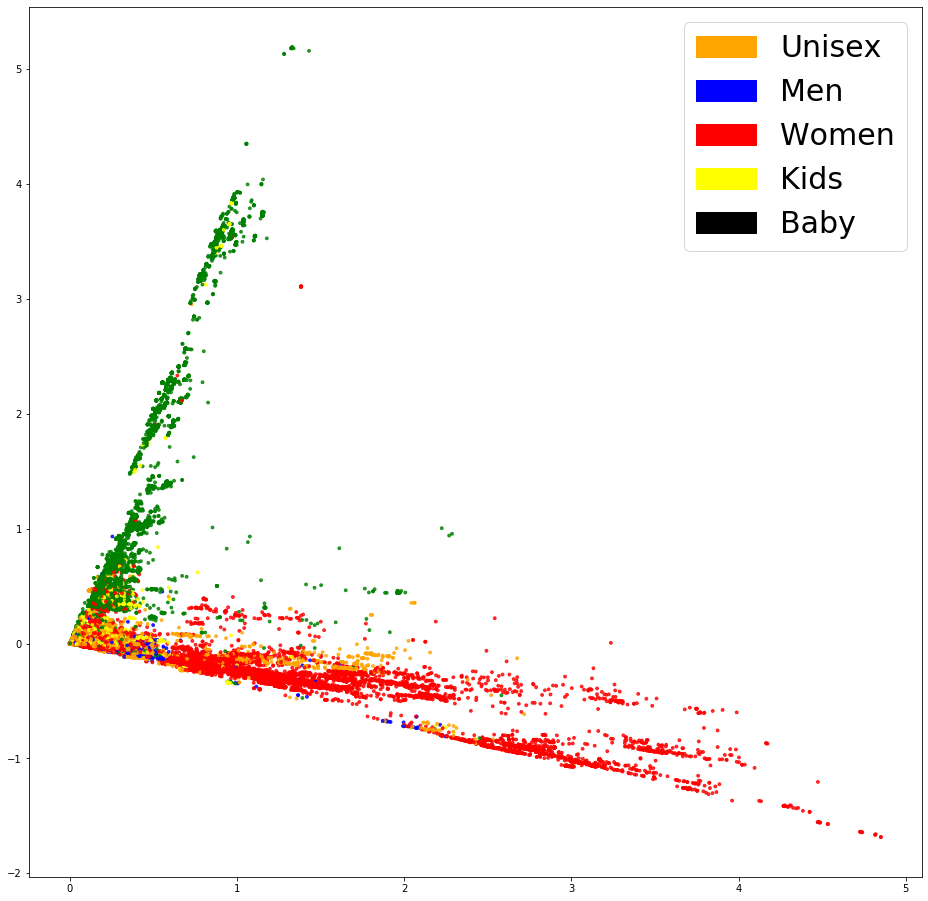

In [196]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','red', 'yellow', 'green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Unisex')
            blue_patch = mpatches.Patch(color='blue', label='Men')
            red_patch = mpatches.Patch(color='red', label='Women')
            yellow_patch = mpatches.Patch(color='yellow', label='Kids')
            green_patch = mpatches.Patch(color='black', label='Baby')
            plt.legend(handles=[orange_patch, blue_patch, red_patch,yellow_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [197]:
#display(df.head())
#display(labeled_data.head())

print(df.shape)
print(labeled_data.shape)

(500000, 16)
(109950, 17)


## Fitting logistic regression


In [198]:

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

## Let's see how confident is our classifier 

In [199]:
allRecords_probabilty=clf.predict_proba(X_test_counts)

allRecords_max_probabilty = []
for i in range(0, allRecords_probabilty.shape[0]):
    probablities=allRecords_probabilty[i]
    prob_index= np.argmax(probablities)
    prob_max= max(probablities)
    allRecords_max_probabilty.append(prob_max)
    


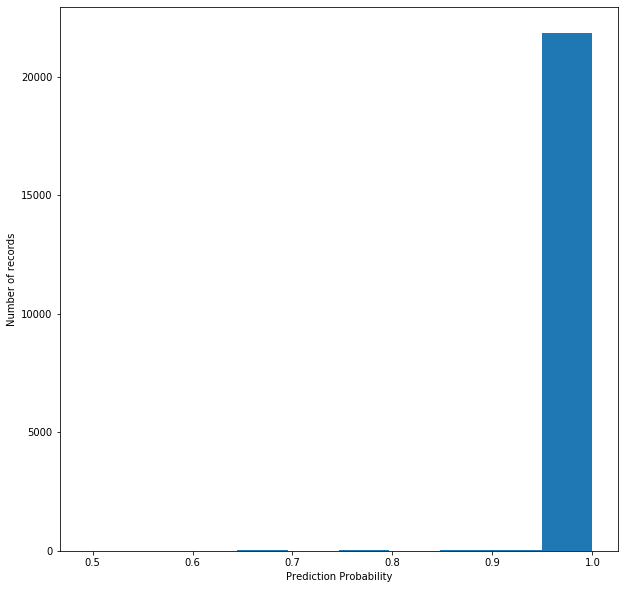

In [200]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Prediction Probability')
plt.ylabel('Number of records')
plt.hist(allRecords_max_probabilty)
plt.show()

## Evaluation

In [201]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.998, precision = 0.998, recall = 0.998, f1 = 0.998


## Inspection
 Let's start by looking at the confusion matrix.


import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

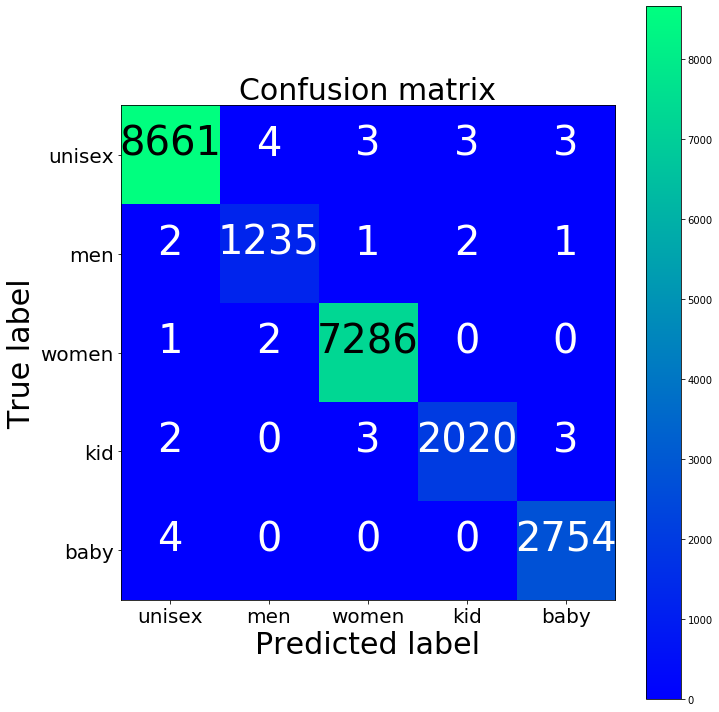

[[8661    4    3    3    3]
 [   2 1235    1    2    1]
 [   1    2 7286    0    0]
 [   2    0    3 2020    3]
 [   4    0    0    0 2754]]


In [202]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, title='Confusion matrix')
plt.show()
print(cm)

## Further inspection
Let's look at the features our classifier is using to make decisions.

In [203]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 15)


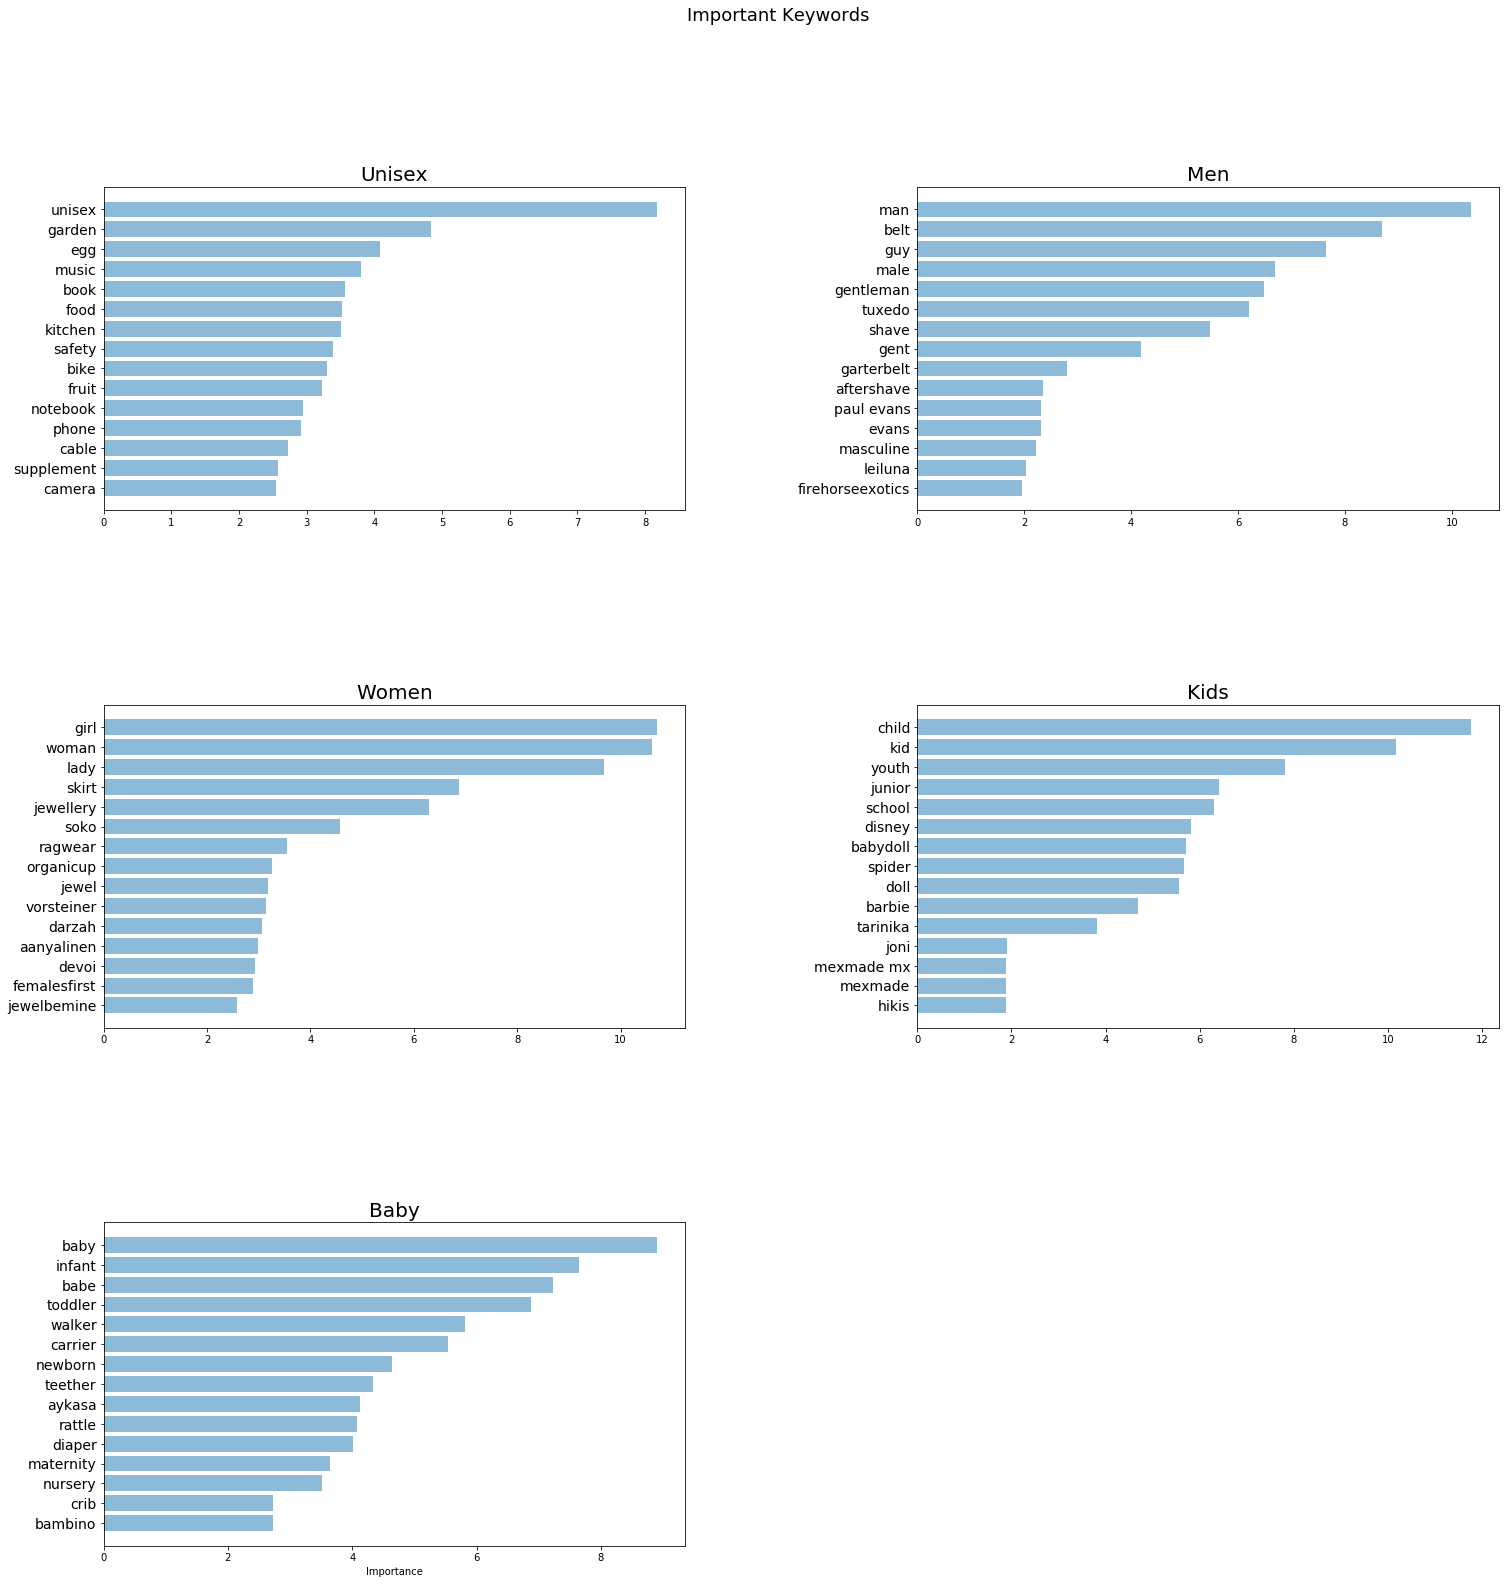

In [204]:


def plot_important_words( top_words, top_scores, label, position):

    y_pos = np.arange(len(top_words))
    plt.subplot(position)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title(label, fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)




top_scores_unisex = [a[0] for a in importance[0]['tops']]
top_words_unisex = [a[1] for a in importance[0]['tops']]

top_scores_men = [a[0] for a in importance[1]['tops']]
top_words_men = [a[1] for a in importance[1]['tops']]

top_scores_women = [a[0] for a in importance[2]['tops']]
top_words_women = [a[1] for a in importance[2]['tops']]

top_scores_kid = [a[0] for a in importance[3]['tops']]
top_words_kid = [a[1] for a in importance[3]['tops']]

top_scores_baby = [a[0] for a in importance[4]['tops']]
top_words_baby = [a[1] for a in importance[4]['tops']]

#plot_important_words(top_scores_unisex, top_words_unisex, top_scores_men, top_words_men, "Most important words")


unisex_pairs = [(a,b) for a,b in zip(top_words_unisex, top_scores_unisex)]
men_pairs = [(a,b) for a,b in zip(top_words_men, top_scores_men)]
unisex_pairs = [(a,b) for a,b in zip(top_words_unisex, top_scores_unisex)]
men_pairs = [(a,b) for a,b in zip(top_words_men, top_scores_men)]

fig = plt.figure(figsize=(25, 25))  
plot_important_words(top_words_unisex, top_scores_unisex, "Unisex", 321)   
plot_important_words(top_words_men, top_scores_men, "Men", 322)
plot_important_words(top_words_women, top_scores_women, "Women", 323)
plot_important_words(top_words_kid, top_scores_kid, "Kids", 324)
plot_important_words(top_words_baby, top_scores_baby, "Baby", 325)

plt.subplots_adjust(wspace=0.4, hspace = 0.6)
plt.suptitle("Important Keywords", fontsize=18)
plt.xlabel('Importance')
plt.show()

In [205]:
#from pivottablejs import pivot_ui
#pivot_ui(labeled_data )

## let's see how our CLF model performs on unseen data
We can use the prediction probability as a performance metric

In [206]:
unlabeled_data= df[df['class'] == '-1'].copy()
print(unlabeled_data.shape)
display(unlabeled_data.head())

(390050, 16)


,Unnamed: 0,product_type,vendor_name,title,store_domain,description,all_tokens,vendor_name_original,all_text_original,unisex,men,women,baby,kid,class,all_text
26,26,"['joint', 'support']","['trace', 'mineral']","['activjoint', 'platinum']",['xsnonline'],[],"['joint', 'support', 'trace', 'mineral', 'activjoint', 'platinum', 'xsnonline']",trace minerals,Joint SupportTrace MineralsActivJoint™ Platinumxsnonline.comnan,0,0,0,0,0,-1,joint support trace mineral activjoint platinum xsnonline
32,32,[],"['trace', 'mineral', 'research']","['trace', 'mineral', 'research', 'ionic', 'iodine']",['oakstreetvitamins'],[],"['trace', 'mineral', 'research', 'trace', 'mineral', 'research', 'ionic', 'iodine', 'oakstreetvi...",trace minerals research,nanTrace Minerals ResearchTrace Minerals Research Ionic Iodineoakstreetvitamins.comnan,0,0,0,0,0,-1,trace mineral research trace mineral research ionic iodine oakstreetvitamins
33,33,"['personal', 'care']","['trace', 'mineral']","['stress', 'x', 'magnesium', 'powder']",['xsnonline'],[],"['personal', 'care', 'trace', 'mineral', 'stress', 'x', 'magnesium', 'powder', 'xsnonline']",trace minerals,Personal CareTrace MineralsStress-X Magnesium Powderxsnonline.comnan,0,0,0,0,0,-1,personal care trace mineral stress x magnesium powder xsnonline
34,34,['regular'],"['trace', 'mineral']","['tmrfit', 'post', 'workout', '16', '2', 'oz']",['sunflowershoppe'],[],"['regular', 'trace', 'mineral', 'tmrfit', 'post', 'workout', '16', '2', 'oz', 'sunflowershoppe']",trace minerals,REGULARTRACE MINERALSTMRFIT POST WORKOUT 16.2 OZsunflowershoppe.comnan,0,0,0,0,0,-1,regular trace mineral tmrfit post workout 16 2 oz sunflowershoppe
38,38,['regular'],"['trace', 'mineral', 'research']","['electrolyte', 'stamen', 'power', 'cranberry', '7', '0g']",['sunflowershoppe'],[],"['regular', 'trace', 'mineral', 'research', 'electrolyte', 'stamen', 'power', 'cranberry', '7', ...",trace minerals research,REGULARTRACE MINERALS RESEARCHELECTROLYTE STAMINA POWER CRANBERRY 7.0Gsunflowershoppe.comnan,0,0,0,0,0,-1,regular trace mineral research electrolyte stamen power cranberry 7 0g sunflowershoppe


In [207]:


list_corpus = unlabeled_data["all_text"].tolist()
#list_labels = unlabeled_data["labels"].tolist()
X_test_counts = count_vectorizer.transform(list_corpus)
y_test_counts = clf.predict(X_test_counts)

# add prediction to the unlabeled_data dataframe
unlabeled_data['labels']=y_test_counts
unlabeled_data['class']=unlabeled_data['labels'].apply( classes.__getitem__)
print(X_test_counts.shape)

(390050, 276262)


In [208]:
allRecords_probabilty=clf.predict_proba(X_test_counts)

allRecords_max_probabilty = []
for i in range(0, allRecords_probabilty.shape[0]):
    probablities=allRecords_probabilty[i]
    prob_index= np.argmax(probablities)
    prob_max= max(probablities)
    allRecords_max_probabilty.append(prob_max)

# add prediction probability to the unlabeled_data dataframe
unlabeled_data['probability']= allRecords_max_probabilty
unlabeled_data.head()

,Unnamed: 0,product_type,vendor_name,title,store_domain,description,all_tokens,vendor_name_original,all_text_original,unisex,men,women,baby,kid,class,all_text,labels,probability
26,26,"['joint', 'support']","['trace', 'mineral']","['activjoint', 'platinum']",['xsnonline'],[],"['joint', 'support', 'trace', 'mineral', 'activjoint', 'platinum', 'xsnonline']",trace minerals,Joint SupportTrace MineralsActivJoint™ Platinumxsnonline.comnan,0,0,0,0,0,unisex,joint support trace mineral activjoint platinum xsnonline,0,0.986288
32,32,[],"['trace', 'mineral', 'research']","['trace', 'mineral', 'research', 'ionic', 'iodine']",['oakstreetvitamins'],[],"['trace', 'mineral', 'research', 'trace', 'mineral', 'research', 'ionic', 'iodine', 'oakstreetvi...",trace minerals research,nanTrace Minerals ResearchTrace Minerals Research Ionic Iodineoakstreetvitamins.comnan,0,0,0,0,0,unisex,trace mineral research trace mineral research ionic iodine oakstreetvitamins,0,0.997089
33,33,"['personal', 'care']","['trace', 'mineral']","['stress', 'x', 'magnesium', 'powder']",['xsnonline'],[],"['personal', 'care', 'trace', 'mineral', 'stress', 'x', 'magnesium', 'powder', 'xsnonline']",trace minerals,Personal CareTrace MineralsStress-X Magnesium Powderxsnonline.comnan,0,0,0,0,0,unisex,personal care trace mineral stress x magnesium powder xsnonline,0,0.991291
34,34,['regular'],"['trace', 'mineral']","['tmrfit', 'post', 'workout', '16', '2', 'oz']",['sunflowershoppe'],[],"['regular', 'trace', 'mineral', 'tmrfit', 'post', 'workout', '16', '2', 'oz', 'sunflowershoppe']",trace minerals,REGULARTRACE MINERALSTMRFIT POST WORKOUT 16.2 OZsunflowershoppe.comnan,0,0,0,0,0,unisex,regular trace mineral tmrfit post workout 16 2 oz sunflowershoppe,0,0.993897
38,38,['regular'],"['trace', 'mineral', 'research']","['electrolyte', 'stamen', 'power', 'cranberry', '7', '0g']",['sunflowershoppe'],[],"['regular', 'trace', 'mineral', 'research', 'electrolyte', 'stamen', 'power', 'cranberry', '7', ...",trace minerals research,REGULARTRACE MINERALS RESEARCHELECTROLYTE STAMINA POWER CRANBERRY 7.0Gsunflowershoppe.comnan,0,0,0,0,0,unisex,regular trace mineral research electrolyte stamen power cranberry 7 0g sunflowershoppe,0,0.993328


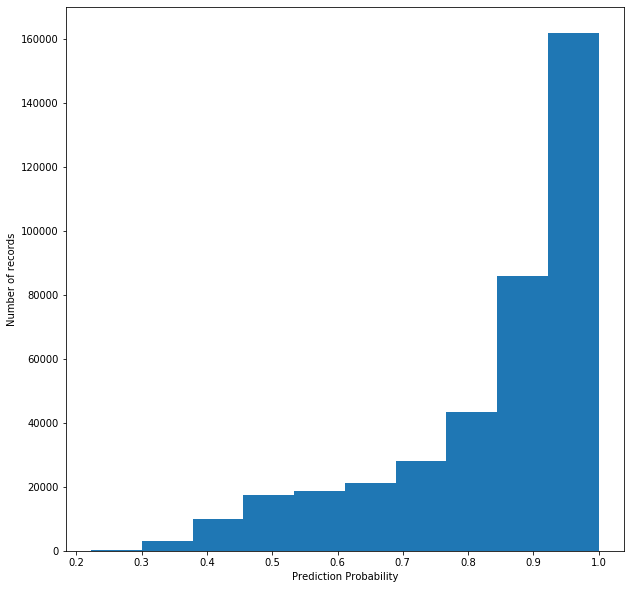

In [209]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Prediction Probability')
plt.ylabel('Number of records')
plt.hist(allRecords_max_probabilty)
plt.show()

In [210]:
confidence_threshold=0.8
high_confidence=unlabeled_data[unlabeled_data['probability']>= confidence_threshold] 
high_confidence_size=high_confidence.shape[0]
low_confidence_size=unlabeled_data.shape[0]-  high_confidence_size
print( "Number of records predicted with high confidence is {} out of {}".format( high_confidence_size, unlabeled_data.shape[0]))
print( "Number of records predicted with low confidence is {} out of {}".format( low_confidence_size, unlabeled_data.shape[0]))

Number of records predicted with high confidence is 275679 out of 390050
Number of records predicted with low confidence is 114371 out of 390050


## Let's select 10 random records and check their prediction manually

In [211]:
import random 

random_records=random.sample(high_confidence.index.to_list(), k=10) 
print(random_records)
unlabeled_data.loc[random_records]

[327410, 14633, 16120, 466252, 339349, 371585, 24268, 308980, 117461, 340975]


,Unnamed: 0,product_type,vendor_name,title,store_domain,description,all_tokens,vendor_name_original,all_text_original,unisex,men,women,baby,kid,class,all_text,labels,probability
327410,327410,"['n', 'p', 'nzt', 'rca']","['kate', 'spade', 'new', 'york']","['kate', 'spade', 'new', 'york', '43230', '53649', 'p', 'nzt', 'rca']",['oravasarlas'],[],"['n', 'p', 'nzt', 'rca', 'kate', 'spade', 'new', 'york', 'kate', 'spade', 'new', 'york', '43230'...",kate spade new york,Női pénztárcakate spade new yorkKate Spade New York 43230-53649 Pénztárcaoravasarlas.comnan,0,0,0,0,0,unisex,n p nzt rca kate spade new york kate spade new york 43230 53649 p nzt rca oravasarlas,0,0.981211
14633,14633,['toy'],['mindzai'],"['20', ""''"", 'plush', 'dunny', 'black', 'edition', 'kidrobot', 'special', 'order']","['mindzai', 'ca']",[],"['toy', 'mindzai', '20', ""''"", 'plush', 'dunny', 'black', 'edition', 'kidrobot', 'special', 'ord...",mindzai,"ToysMindzai20"" Plush Dunny - Black Edition by Kidrobot - Special Ordermindzai.canan",0,0,0,0,0,unisex,toy mindzai 20 '' plush dunny black edition kidrobot special order mindzai ca,0,0.940145
16120,16120,"['health', 'beauty', 'fragrance', 'men', ""'s"", 'fragrance']","['sean', 'john']","['3', 'sean', 'john', '0', '5', 'eau', 'de', 'toilette', 'spray', 'men']",['airdamour'],[],"['health', 'beauty', 'fragrance', 'men', ""'s"", 'fragrance', 'sean', 'john', '3', 'sean', 'john',...",sean john,Health & Beauty:Fragrances:Men's FragrancesSean John3 Am by Sean John 0.5 Eau De Toilette Spray ...,0,0,0,0,0,men,health beauty fragrance men 's fragrance sean john 3 sean john 0 5 eau de toilette spray men air...,1,0.836070
466252,466252,"['samsung', 'galaxy', 'note10']",['awara'],"['shade', 'brown', 'samsung', 'galaxy', 'note10', 'mobile', 'cover']",['beawara'],[],"['samsung', 'galaxy', 'note10', 'awara', 'shade', 'brown', 'samsung', 'galaxy', 'note10', 'mobil...",be awara,Samsung Galaxy Note10+Be AwaraShades of Brown Samsung Galaxy Note10+ Mobile Coverbeawara.comnan,0,0,0,0,0,unisex,samsung galaxy note10 awara shade brown samsung galaxy note10 mobile cover beawara,0,0.908037
339349,339349,"['shirt', 'casual']","['j', 'bale']","['tomlinson', 'knit', 'shirt']",['mjbale'],[],"['shirt', 'casual', 'j', 'bale', 'tomlinson', 'knit', 'shirt', 'mjbale']",m.j. bale,Shirts CasualM.J. BaleTomlinson Knit Shirtmjbale.comnan,0,0,0,0,0,unisex,shirt casual j bale tomlinson knit shirt mjbale,0,0.802996
371585,371585,['stationery'],"['look', 'happen', 'x', 'navvi']","['donut', 'diary']",['navvi'],[],"['stationery', 'look', 'happen', 'x', 'navvi', 'donut', 'diary', 'navvi']",look what happened x navvi,StationeryLook What Happened x NavviDONUT Diarynavvi.innan,0,0,0,0,0,unisex,stationery look happen x navvi donut diary navvi,0,0.990927
24268,24268,"['clothing', 'jacket']",['spika'],"['spika', 'anorak', 'olive']","['mansfieldhuntingandfishing', 'au']",[],"['clothing', 'jacket', 'spika', 'spika', 'anorak', 'olive', 'mansfieldhuntingandfishing', 'au']",spika,CLOTHING-JACKETSSPIKASPIKA ANORAK OLIVEmansfieldhuntingandfishing.com.aunan,0,0,0,0,0,unisex,clothing jacket spika spika anorak olive mansfieldhuntingandfishing au,0,0.866397
308980,308980,[],"['copper', 'pearl']","['set', '3', 'copper', 'pearl', 'bandana', 'adjustable', 'bib']",['shopcopito'],[],"['copper', 'pearl', 'set', '3', 'copper', 'pearl', 'bandana', 'adjustable', 'bib', 'shopcopito']",copper pearl,nanCopper pearlSet of 3 copper pearl bandana adjustable bibsshopcopito.comnan,0,0,0,0,0,baby,copper pearl set 3 copper pearl bandana adjustable bib shopcopito,4,0.967447
117461,117461,[],['splitsbyanderson'],"['vanta', 'black', 'suede', 'moccasin']",['split'],[],"['splitsbyanderson', 'vanta', 'black', 'suede', 'moccasin', 'split']",splitsbyanderson,nansplitsbyandersonVanta Black Suede Moccasinsplits.innan,0,0,0,0,0,unisex,splitsbyanderson vanta black suede moccasin split,0,0.873818
340975,340975,[],['clover'],"['clover', 'mark', 'pin', 'knit', 'art', '325']","['flyingbear', 'sg']",[],"['clover', 'c

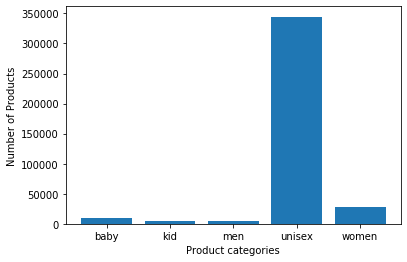

-1        390050
unisex     43374
women      36481
baby       13631
kid        10272
men         6192
Name: class, dtype: int64


In [212]:
plot_class_distribution (unlabeled_data, 'product_type','class', starting_index=0)
print(df['class'].value_counts())

In [218]:
pd.options.display.max_colwidth = 100
rows=unlabeled_data['class']=='baby'
print(unlabeled_data.loc[rows,['class','all_text_original', 'probability']])
pd.options.display.max_colwidth=50

       class  \
672     baby   
675     baby   
694     baby   
11143   baby   
12040   baby   
...      ...   
496205  baby   
496233  baby   
496270  baby   
496866  baby   
496883  baby   

                                                                                          all_text_original  \
672        Disposal LinersOmaikiOmaiki -Disposable 100% Bamboo Liners 100 Liners Per Rollcutelittleme.canan   
675                              nanOmaikiOmaiki HERÖ Daytime Training Pants - Pull Uplilmonkeycheeks.canan   
694                           nanOmaikiOmaiki HERÖ Daytime Training Pants - Side Snapslilmonkeycheeks.canan   
11143                      MiscellaneousCooter'sMBCarver Race Car Pencil (Bo's Race Car)cootersplace.comnan   
12040               nanMoira CosmeticsMoira Cosmetics - Lip Exposure Pencil - Pink Blushbaygiftvault.comnan   
...                                                                                                     ...   
496205  Star WarsEBuycosStar W

In [214]:
pd.options.display.max_colwidth=50